# Laplace's equation

In [2]:
# Import libraries.
from matplotlib import pyplot, cm
from mpl_toolkits import mplot3d
import numpy

%matplotlib inline

In [3]:
# Change default font family and size for Matplotlib figures.
pyplot.rc('font', family='serif', size=16)

## Problem setup

Solve the Laplace's equation $\nabla^2 u = 0$ in the domain $\Omega = \left[ 0, L_x \right] \times \left[ 0, L_y \right]$

<img src="figures/application_setup.png" alt="application_setup" width="300"/>

Initial guess: $u = 0$ everywhere inside the domain.

## Analytical solution

$$
u \left( x, y \right) = \frac{\sinh \left( \frac{3}{2} \pi \frac{y}{L_y} \right)}{\sinh \left( \frac{3}{2} \pi \frac{L_x}{L_y} \right)} \sin \left( \frac{3}{2} \pi \frac{x}{L_x} \right)
$$

In [9]:
def laplace_solution(x, y, Lx, Ly):
    """Return the analytical solution.

    Parameters
    ----------
    x : numpy.ndarray
        Coordinates along the x direction as a 1D array of floats.
    y : numpy.ndarray
        Coordinates along the y direction as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.

    Returns
    -------
    u : numpy.ndarray
        The analytical solution as a 2D array of floats.

    """
    X, Y = numpy.meshgrid(x, y)
    u = (numpy.sinh(1.5 * numpy.pi * Y / Ly) /
         numpy.sinh(1.5 * numpy.pi * Ly / Lx) *
         numpy.sin(1.5 * numpy.pi * X / Lx))
    
    return u

In [50]:
def plot_3d(x, y, u, label='$z$', elev=30.0, azim=45.0):
    """Create a 3D surface plot of the scalar field `u`.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    u : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction; default: 'z'.
    elev : float, optional
        Elevation angle in the z plane; default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane; default: 45.0.

    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, u, cmap=cm.rainbow)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

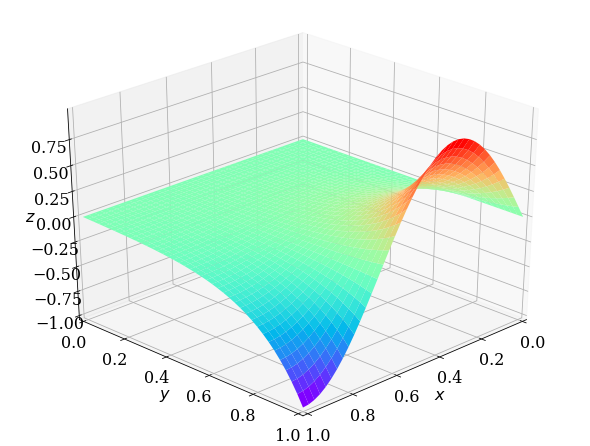

In [51]:
# Set parameters.
Lx, Ly = 1.0, 1.0  # lengths of the domain
nx, ny = 41, 41  # number of points along each direction

# Define grid-point locations.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

u = laplace_solution(x, y, Lx, Ly)

plot_3d(x,y,u)

## Initial solution

<img src="figures/application_setup.png" alt="application_setup" width="300"/>

Initial guess: $u = 0$ everywhere inside the domain.

Boundary values:

* Bottom and left: $u = 0$
* Top: $u = \sin \left( \frac{3}{2} \pi \frac{x}{L_x} \right)$
* Right: $\frac{\partial u}{\partial x} = 0$

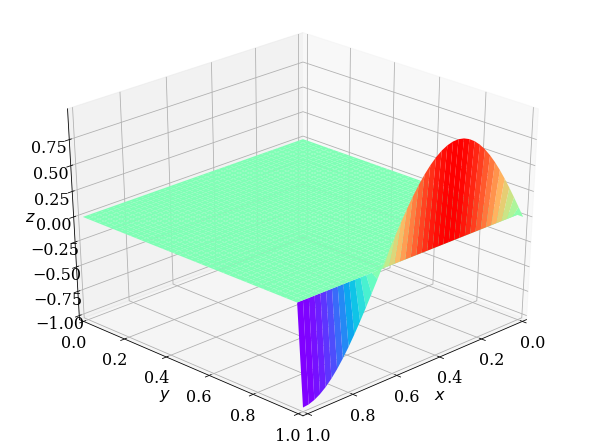

In [52]:
# Initial Solution / Initial Guess
u0=numpy.zeros((ny, nx))
u0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)


###
# To do: Plot the initial guess.

plot_3d(x,y,u0)
###


## Jacobi method

$$
u_{i, j}^{k+1} = \frac{1}{4} \left( u_{i, j-1}^k + u_{i-1, j}^k + u_{i+1, j}^k + u_{i, j+1}^k \right)
$$

In [45]:
def laplace_2d_jacobi(u0, maxiter=20000, rtol=1e-8):
    """Solve the 2D Laplace equation using Jacobi method.

    Parameters
    ----------
    u0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform; default: 20000.
    rtol : float, optional
        Relative tolerance for convergence; default: 1e-8.

    Returns
    -------
    u : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations computed.
    diff : float
        The final relative L2-norm of the difference.

    """
    u = u0.copy()  # create copy to not overwrite initial guess
    diff = rtol + 1.0  # initialize residual to "high" value
    ite = 0  # initialize iteration index
    while diff > rtol and ite < maxiter:
        un = u.copy()  # store the solution at previous iteration
        
        #Update solution at interior points below using Jacobi
        u[1:-1, 1:-1] = (1/4) * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        
        #Apply Neumann at boundary (R-boundary)
        u[1:-1, -1] = u[1:-1, -2]
        
        # Compute residual as L2-Norm of difference
        diff = numpy.linalg.norm(u - un) / numpy.linalg.norm(un)
        
        ite += 1  # update the iteration index
        ###
        ###

    return u, ite, diff

In [46]:
# L2- Norm Difference Function
def l2_norm(u, u_ref):
    l2_diff = (numpy.sqrt(numpy.sum((u-u_ref)**2)) / 
              numpy.sqrt(numpy.sum(u_ref**2)))
    return l2_diff

Jacobi Relaxation: 4473 iterations to reach relative difference of 9.989253685041417e-09


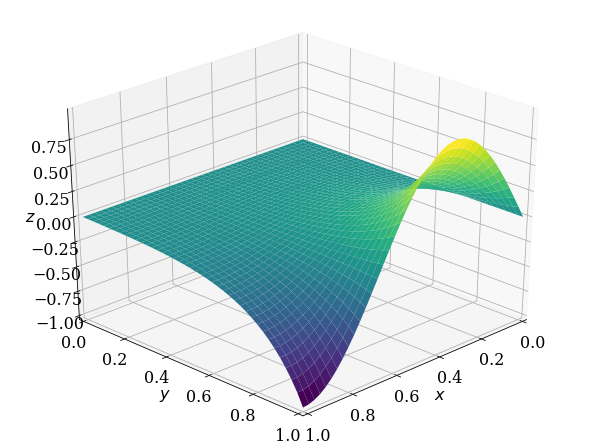

In [47]:
###
# To do: Compute the numerical solution of the Laplace equation.
# Question: How many iterations was needed?
# Question: What's the value of the final residual?
###
u, ites, diff = laplace_2d_jacobi(u0, rtol=1e-8)
print('Jacobi Relaxation: {} iterations '.format(ites) + 'to reach relative difference of {}'.format(diff))
###
plot_3d(x,y,u)
###


## Convergence analysis

In [55]:
# List of grid-spacing sizes to investigate.
dx_vals = [0.1, 0.05, 0.025, 0.0125]


# Empty list to store the error on each grid.
errors = []

for dx in dx_vals:
    ###
    # To do: Re-create the space grid.
    nx = int(Lx/dx) + 1
    ny = int(Ly/dx) + 1
    x = numpy.linspace(0, Lx, num=nx)
    y = numpy.linspace(0, Ly, num=ny)
    # To do: re-set the initial guess.
    u0 = numpy.zeros((ny, nx))
    u0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)
    
    # To do: Relax the solution with Jacobi.
    u, _, _ = laplace_2d_jacobi(u0, rtol=1e-8) #underscores show that those values are not insignificant and only the first one does
   
    # To do: Compute the analytical solution.
    u_exactly = laplace_solution(x,y,Lx,Ly)
   
    # To do: Compute and append the relative L2 error to `errors`.
    errors.append(l2_norm(u, u_exactly))

The order of convergence should be 2nd order convergence for second order equation


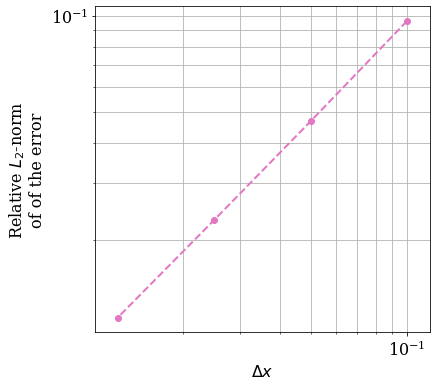

In [64]:
###
# To do: Plot (loglog) the error versus the grid-spacing size.
# Question: What's the order of convergence?

pyplot.figure(figsize=(6.0, 6.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof of the error')
pyplot.grid(which='both')
pyplot.loglog(dx_vals, errors, color='C6', linestyle = '--', linewidth = 2, marker='o')
pyplot.axis('equal');
###
print('The order of convergence should be 2nd order convergence for second order equation')

## 2nd-order Neumann boundary conditions

In [66]:
def laplace_2d_jacobi_neumann(u0, maxiter=20000, rtol=1e-8):
    """Solve the 2D Laplace equation using Jacobi method.

    Use a second-order approximation for Neumann boundary conditions.

    Parameters
    ----------
    u0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform; default: 20000.
    rtol : float, optional
        Relative tolerance for convergence; default: 1e-8.

    Returns
    -------
    u : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    diff : float
        The final relative L2-norm of the difference.

    """
    u = u0.copy()  # create copy to not overwrite initial guess
    diff = rtol + 1.0  # initialize residual to "high" value
    ite = 0  # initialize iteration index
    while diff > rtol and ite < maxiter:
        un = u.copy()  # store the solution at previous iteration
        
        # Update interior pts solution
        u[1:-1, 1:-1] = (1/4) * (u[1:-1, :-2] + u[1:-1, 2:] + 
                                 u[:-2, 1:-1] + u[2:, 1:-1])
        
        # 2nd Order Neumann condition (zero-grad) at R-Boundary
        u[1:-1, -1] = (1/4) * (2.0 * un[1:-1, -2] + un[2:, -1] + un[:-2, -1])
        
        # Compute Diff
        diff = l2_norm(u,un)
        
        ite += 1  # update the iteration index
        ###
        # To do: Update the solution using Jacobi method.
        # To do: Update the value at boundaries (where necessary).
        # To do: Compute `diff`, the relative L2-norm of the difference
        # in the solution between two successive iterations.
        ###
        
    return u, ite, diff

## Re-do convergence analysis

In [73]:
# List of grid-spacing sizes to investigate.
dx_vals = [0.1, 0.05, 0.025, 0.0125]

# Empty list to store the error on each grid.
errors = []

for dx in dx_vals:
    ###
    # Re-create spae grid
    nx = int(Lx/dx) + 1
    ny = int(Ly/dx) + 1
    x = numpy.linspace(0, Lx, num=nx)
    y = numpy.linspace(0, Ly, num=ny)
    
    # Reset initial guess
    u0 = numpy.zeros((ny, nx))
    u0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)
    
    #Jacobi Solution Relax
    u, _, _ = laplace_2d_jacobi_neumann(u0, rtol=1e-8)
        
    # Compute Analytical Solution
    u_exact = laplace_solution(x,y,Lx,Ly)
    
    #Error Norm and Stuff
    errors.append(l2_norm(u,u_exact))
    
    # To do: Re-create the space grid.
    # To do: re-set the initial guess.
    # To do: Relax the solution with Jacobi.
    # To do: Compute the analytical solution.
    # To do: Compute and append the relative L2 error to `errors`.
    ###
    

The Order of Convergence is 2nd order (and actually is this time )


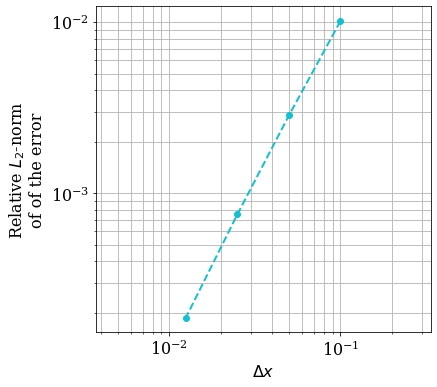

In [85]:
###
# To do: Plot (loglog) the error versus the grid-spacing size.
# Question: What's the order of convergence?
###

pyplot.figure(figsize=(6.0, 6.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof of the error')
pyplot.grid(which='both')
pyplot.loglog(dx_vals, errors, color='C9', linestyle = '--', linewidth = 2, marker='o')
pyplot.axis('equal');

print('The Order of Convergence is 2nd order (and actually is this time )')